## Project 4

## Video

The same transformation, demonstrated above, should be applied to videos as well. We will use the sample video to see how our algorithm performs

I will start with the basics: create a pipeline of transformations, and apply it to video, similar to what has been done in project 1.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.gridspec as gs
%matplotlib inline

In [86]:
def get_perspective_tranform(mtx, dist, nx=9, ny=6, offset=300, img_file='test_images/straight_lines1.jpg'):
    """ Calculate source and destination to be used for warping image"""

    # preprocess image
    sample_img = mpimg.imread(img_file)
    undist_img = cv2.undistort(sample_img, mtx, dist, None, mtx)

    # define source
    # src = np.array([[609, 440],[668, 440],[1030,675],[276,675]], dtype=np.float32)
    #src = np.array([[594, 450],[686, 450],[1085,700],[220,700]], dtype=np.float32)
    #src = np.array([[610, 440],[669, 440],[1090,700],[218,700]], dtype=np.float32)
    src = np.array([[610, 440],[667, 440],[1050,675],[260,675]], dtype=np.float32)
    
    # calculate destination
    h,w = undist_img.shape[:2]
    dst = np.array([[offset,0],[w-offset,0],
                    [w-offset, h],[offset, h]], 
                   dtype=np.float32)

    # get matrix M
    M = cv2.getPerspectiveTransform(src,dst)

    return M

In [87]:
from support_func import *

ret, mtx, dist, rvecs, tvecs = calibrate_camera()
M = get_perspective_tranform(mtx, dist)
Minv = np.linalg.inv(M)
sample_img= mpimg.imread('test_images/straight_lines1.jpg')

In [1]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, img_shape):
        self.fits = []
        self.memory_size = 5
        self.count_trues = 0
        self.count_falses = 0 

        
    def add_fit(self, new_fit):
        if len(self.fits) >= self.memory_size:
            self.fits.pop(0)
        self.fits.append(new_fit)
        

    def get_best_fit(self):
        """ Use a moving average to determine best fit
        Uses past 5 results as input, if available """

        weights=range(1,self.memory_size+1)
        return np.ma.average(self.fits, weights=weights[:len(self.fits)], axis=0)  


In [141]:
def process_image(image, debug=False):
    
    ## Undistort image, based on previous camera calibration
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)

    # warp image    
    warped_img = cv2.warpPerspective(undist_img, M, (image.shape[1],image.shape[0]), 
                                    flags=cv2.INTER_LINEAR)
    
    
    ## Preprocesss
    combined = preprocess(warped_img)

    lefty, leftx, righty, rightx = get_lane_points_first_frame(combined)

    # fitting a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    lvalid = True
    rvalid = True
    
    # base points
    if leftx[0] < 200 or leftx[0] > 450:
        lvalid = False
    if rightx[0] < 900 or rightx[0] > 1100:
        rvalid = False
    
    # curvature
    curvature_left = measure_curvature(lefty, leftx, left_fit)
    curvature_right = measure_curvature(righty, rightx, right_fit)
    if curvature_left >= curvature_right:
        cratio = curvature_left/curvature_right
    else:
        cratio = curvature_right/curvature_left
    if cratio > 2.0:
        lvalid = False
        rvalid = False
        
    # measure base distance and top distance
    xm_per_pix = 3.7/700
    base_distance = abs(leftx[0] - rightx[0])*xm_per_pix
    top_distance = abs(leftx[-1] - rightx[-1])*xm_per_pix
    if (base_distance < 3.30 or base_distance > 3.90) or \
        (top_distance < 2.00 or top_distance > 5.00):
        lvalid = False
        rvalid = False
                    
    # check if left lane is valid
    if not lvalid:
        ll.count_falses += 1
    else:
        ll.count_trues += 1
        ll.add_fit(left_fit)

    # check if right lane is valid
    if not rvalid:
        rl.count_falses += 1
    else:
        rl.count_trues += 1
        rl.add_fit(right_fit)
    
    # change to best fit if in video
    if ll.fits != []:
        left_fit = ll.get_best_fit()
    if rl.fits != []:
        right_fit = rl.get_best_fit()
        
    # extrapolating points
    fity = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]       

    # weighted_img = draw_lanes(image, fit_leftx, fit_rightx, fity, Minv)
    if debug:
        weighted_img = debug_lanes(combined, fit_leftx, fit_rightx, fity, left_fit, right_fit, Minv)
    else:
        weighted_img = draw_lanes(image, fit_leftx, fit_rightx, fity, Minv)

    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if debug:
        txt1 = "Ratio of radius of curvature= {:.2f}".format(cratio)
        cv2.putText(weighted_img,txt1,(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt2 = "Base distance = {:.2f}(m)".format(base_distance)
        cv2.putText(weighted_img,txt2,(20,180), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt3 = "Left-valid: {}".format(str(lvalid))
        cv2.putText(weighted_img,txt3,(20,280), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt4 = "Right-valid: {}".format(str(rvalid))
        cv2.putText(weighted_img,txt4,(20,380), font, 2,(255,255,255),2,cv2.LINE_AA)

    else:
        # average curvature
        avg_curvature = int((curvature_left+curvature_right)/2)
        txt1 = "Radius of curvature = {}(m)".format(avg_curvature)
        
        # output
        cv2.putText(weighted_img,txt1,(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)

        # calculating distance from center
        lane_width = abs(rightx[0] - leftx[0])/2
        lane_center = lane_width + leftx[0]
        image_center = image.shape[1]/2
        distance_from_center = (image_center - lane_center)*xm_per_pix
        
        # output
        if distance_from_center > 0:
            txt2 = "Vehicle is = {:.2f}(m) right of center".format(distance_from_center)
        else:
            txt2 = "Vehicle is = {:.2f}(m) left of center".format(-distance_from_center)
        cv2.putText(weighted_img,txt2,(20,180), font, 2,(255,255,255),2,cv2.LINE_AA)
        
    
    ## Warp lanes drawn back to original image
    return weighted_img


In [142]:
def preprocess(img):
    #color
    color_binary = color_thresh(img, thresh=(150,255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(40,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(40,100))
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(20,100))
    dir_binary = dir_thresh(gray, sobel_kernel=15, thresh=(0.70,1.3))

    combined = np.zeros_like(gray)
    combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary==1)) | (color_binary==1)] = 1
    return combined


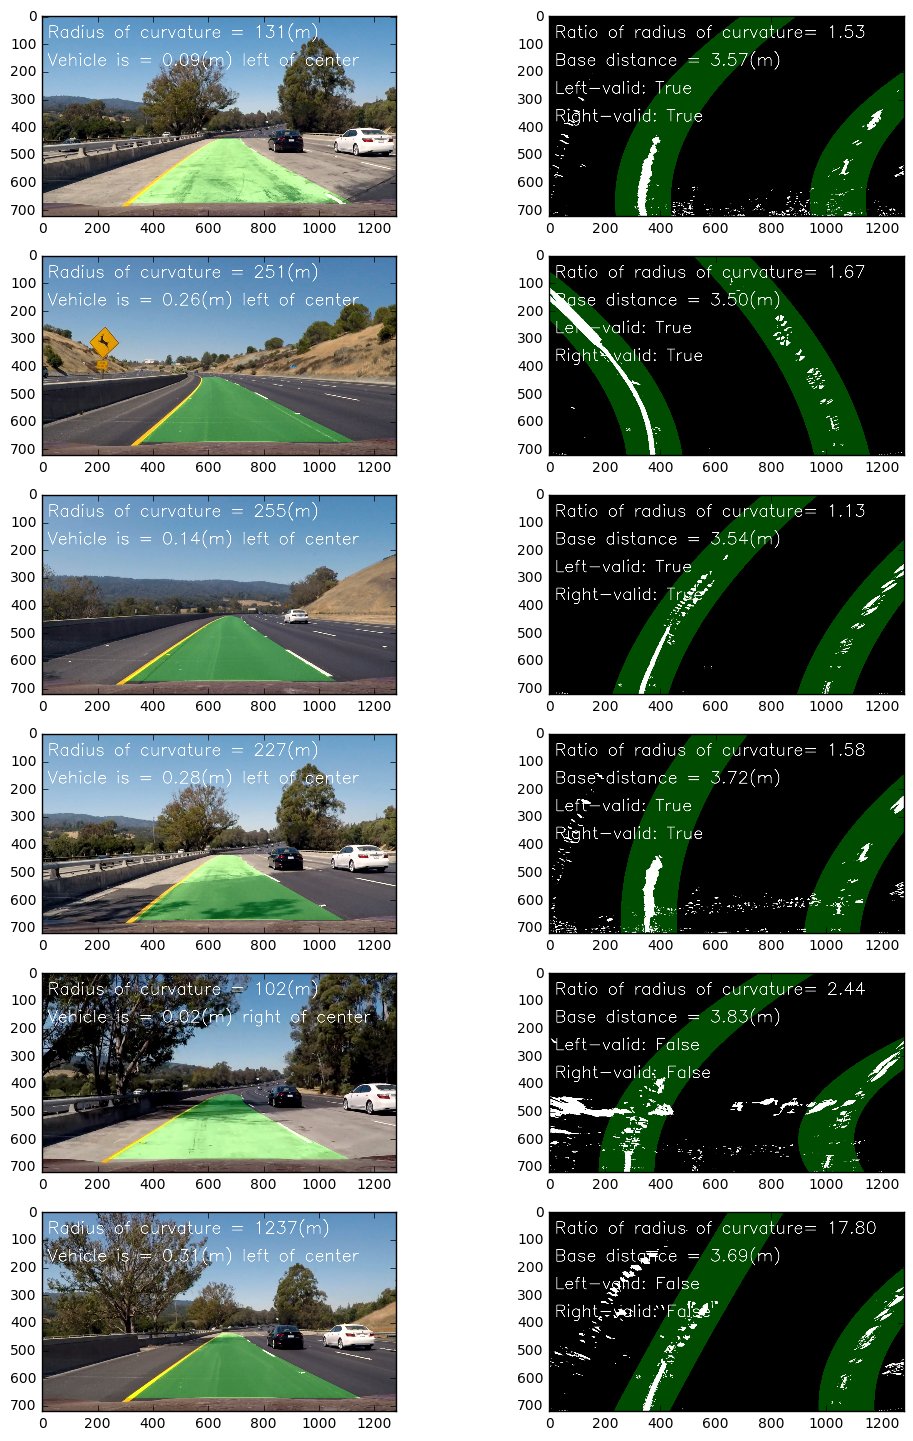

In [143]:
test_images = glob.glob('test_images/test*.jpg')
n = len(test_images)
plt.figure(figsize=(12,n*3))
grid = gs.GridSpec(n,2)

for idx, img_file in enumerate(test_images):
    #create lanes, analyse each image independently
    ll = Line(sample_img.shape[:2])
    rl = Line(sample_img.shape[:2])
    # read in image
    img = mpimg.imread(img_file)
    # plot image
    ax = plt.subplot(grid[idx*2])
    ax.imshow(process_image(img))
    # plot transformed image
    ax = plt.subplot(grid[(idx*2)+1])
    # process image
    ax.imshow(process_image(img, debug=True))
    

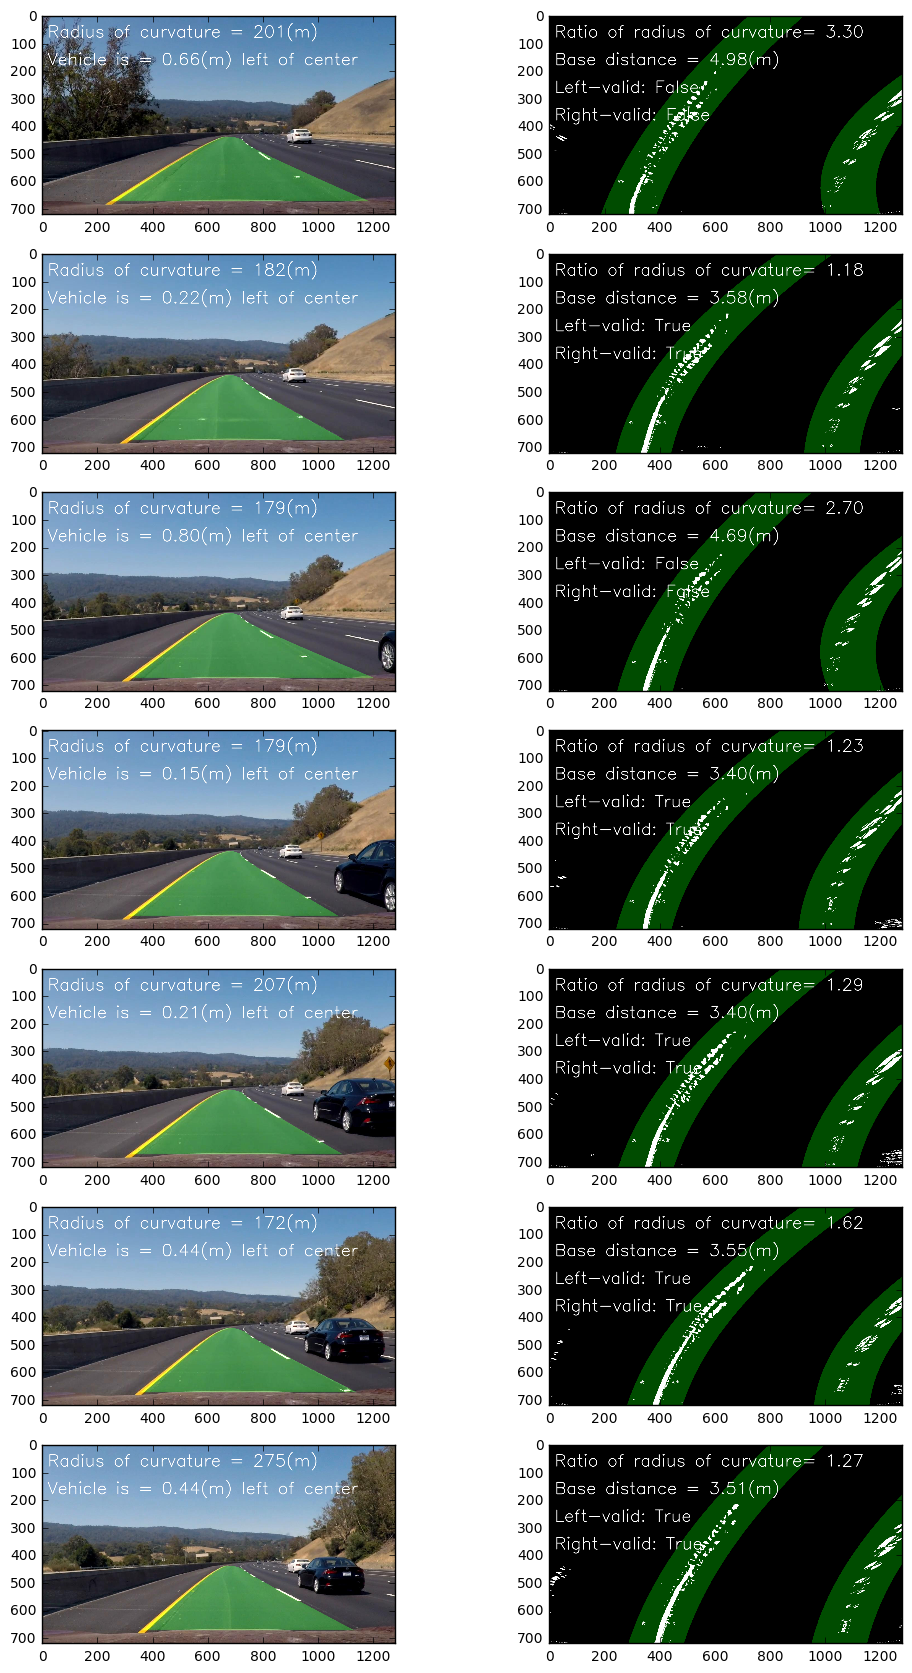

In [145]:
test_images = glob.glob('test_images_3/frame*.jpg')
n = len(test_images)
plt.figure(figsize=(12,n*3))
grid = gs.GridSpec(n,2)

for idx, img_file in enumerate(test_images):
    #create lanes, analyse each image independently
    ll = Line(sample_img.shape[:2])
    rl = Line(sample_img.shape[:2])
    # read in image
    img = mpimg.imread(img_file)
    # plot image
    ax = plt.subplot(grid[idx*2])
    ax.imshow(process_image(img))
    # plot transformed image
    ax = plt.subplot(grid[(idx*2)+1])
    # process image
    ax.imshow(process_image(img, debug=True))

# Project Video

In [148]:
#create lanes
ll = Line(sample_img.shape[:2])
rl = Line(sample_img.shape[:2])

regular_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
regular_clip = clip1.fl_image(process_image) 

%time regular_clip.write_videofile(regular_output, audio=False);

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  4.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 5min 15s, sys: 55.7 s, total: 6min 11s
Wall time: 4min 50s


In [149]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(regular_output))

# Saving test images

In [25]:
clip = VideoFileClip("sample_video_2.mp4")
for t in range(7):
    clip.save_frame("frame_sample{}.png".format(t), t=t)


In [30]:
from PIL import Image

for infile in glob.glob('test_images_3/frame_sample*.png'):
    outfile = infile.replace('.png', '.jpg')
    im = Image.open(infile)
    im.convert('RGB').save(outfile, 'JPEG')

In [10]:
def preprocess(img):
    #color
    color_binary = color_thresh(img, thresh=(150,255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(40,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(40,100))
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(20,100))

    combined = np.zeros_like(gray)
    combined[((gradx_binary == 1) & (grady_binary == 1) & (mag_binary == 1)) | (color_binary==1)] = 1
    return combined
